# Exercise 2 Data Cleaning
---

### Download Packages 

In [1]:
import pandas as pd
import numpy as np
import shared_utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Read in Files

In [2]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/bus_service_increase/"
FILE_NAME = "ntd_metrics_2019.csv"
df_metrics = pd.read_csv(f"{GCS_FILE_PATH}{FILE_NAME}")

In [3]:
#List out columns to see if there are any trailing spaces and whatnot 
list(df_metrics.columns)

['Agency',
 'City',
 'State',
 'Legacy NTD ID',
 'NTD ID',
 'Organization Type',
 'Reporter Type',
 'Primary UZA\n Population',
 'Agency VOMS',
 'Mode',
 'TOS',
 'Mode VOMS',
 'Ratios:',
 'Fare Revenues per Unlinked Passenger Trip ',
 'Fare Revenues per Unlinked Passenger Trip Questionable',
 'Fare Revenues per Total Operating Expense (Recovery Ratio)',
 'Fare Revenues per Total Operating Expense (Recovery Ratio) Questionable',
 'Cost per\n Hour',
 'Cost per Hour Questionable',
 'Passengers per Hour',
 'Passengers per Hour Questionable',
 'Cost per Passenger',
 'Cost per Passenger Questionable',
 'Cost per Passenger Mile',
 'Cost per Passenger Mile Questionable',
 'Source Data:',
 'Fare Revenues Earned',
 'Fare Revenues Earned Questionable',
 'Total Operating Expenses',
 'Total Operating Expenses Questionable',
 'Unlinked Passenger Trips',
 'Unlinked Passenger Trips Questionable',
 'Vehicle Revenue Hours',
 'Vehicle Revenue Hours Questionable',
 'Passenger Miles',
 'Passenger Miles Que

#### Loading Metrics  dataset

In [4]:
df_metrics = df_metrics[["Agency", "City","State","Fare Revenues per Unlinked Passenger Trip ", "Unlinked Passenger Trips", "Fare Revenues per Total Operating Expense (Recovery Ratio)", "Fare Revenues Earned"]]

In [5]:
df_metrics.head(2)

,Agency,City,State,Fare Revenues per Unlinked Passenger Trip,Unlinked Passenger Trips,Fare Revenues per Total Operating Expense (Recovery Ratio),Fare Revenues Earned
0,MTA New York City Transit,New York,NY,$1.34,"2,712,521,697",0.70,"$3,643,213,720"
1,MTA New York City Transit,New York,NY,$6.66,"11,477,164",0.32,"$76,398,352"


#### Loading Vehicle dataset

In [6]:
FILE_TWO = "ntd_vehicles_2019.csv"
df_vehicles = pd.read_csv(f"{GCS_FILE_PATH}{FILE_TWO}")

In [7]:
df_vehicles = df_vehicles.iloc[:, [0,2,5,6,7,93]]

In [8]:
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Agency                  2775 non-null   object
 1   State                   2775 non-null   object
 2   Organization Type       2775 non-null   object
 3   Reporter Type           2775 non-null   object
 4   Primary UZA Population  2775 non-null   object
 5   Total Service Vehicles  2775 non-null   object
dtypes: object(6)
memory usage: 130.2+ KB


### Subsetting for only states of interest


In [9]:
#keeping only the states of interest 
states_to_keep = ["CA", "NY", "TX", "ID", "MS"]
df_vehicles = df_vehicles[df_vehicles.State.isin(states_to_keep)]

In [10]:
#checking that I filtered everything correct 
df_vehicles['State'].unique().tolist()

['NY', 'CA', 'TX', 'ID', 'MS']

### Merging the data with an inner join

In [11]:
merge1 = df_vehicles.merge(df_metrics, how = "inner", on = ["Agency", "State"])


In [12]:
merge1.State.value_counts()

CA    436
TX    167
NY    128
MS     29
ID     28
Name: State, dtype: int64

In [13]:
merge1.head(2)

,Agency,State,Organization Type,Reporter Type,Primary UZA Population,Total Service Vehicles,City,Fare Revenues per Unlinked Passenger Trip,Unlinked Passenger Trips,Fare Revenues per Total Operating Expense (Recovery Ratio),Fare Revenues Earned
0,MTA New York City Transit,NY,"Subsidiary Unit of a Transit Agency, Reporting...",Full Reporter,"18,351,295","2,297",New York,$1.34,"2,712,521,697",0.70,"$3,643,213,720"
1,MTA New York City Transit,NY,"Subsidiary Unit of a Transit Agency, Reporting...",Full Reporter,"18,351,295","2,297",New York,$6.66,"11,477,164",0.32,"$76,398,352"


### Cleaning up the files to remove (), commas, $, and blanks

In [14]:
#removing more columns
merge1 = merge1.drop(['Organization Type', 'Reporter Type'], axis=1)

In [15]:

merge1.columns = merge1.columns.str.strip().str.replace(' ', '_')

In [16]:
#dropping na 
merge1 = merge1.dropna()
merge1.dropna(axis='columns').head(1)

,Agency,State,Primary_UZA_Population,Total_Service_Vehicles,City,Fare_Revenues_per_Unlinked_Passenger_Trip,Unlinked_Passenger_Trips,Fare_Revenues_per_Total_Operating_Expense_(Recovery_Ratio),Fare_Revenues_Earned
0,MTA New York City Transit,NY,"18,351,295","2,297",New York,$1.34,"2,712,521,697",0.70,"$3,643,213,720"


In [17]:
#making sure no nulls
print(merge1.isnull().sum().sum())

0


In [18]:
merge1 = merge1.assign(
    Agency = merge1.Agency.str.strip(),
    Fare_Revenues_per_Unlinked_Passenger_Trip = merge1.Fare_Revenues_per_Unlinked_Passenger_Trip.str.strip().replace({'\$':''}, regex=True),
    City = merge1.City.str.strip(),
    State = merge1.State.str.strip(),
    Total_Service_Vehicles = merge1.Total_Service_Vehicles.str.strip().replace(',','', regex=True),
    Fare_Revenues_Earned = merge1.Fare_Revenues_Earned.str.strip().replace('(126346)', '-126346').replace(',','',regex=True).replace({'\$':''}, regex=True),
    Primary_UZA_Population = merge1.Primary_UZA_Population.str.strip().replace(',','',regex = True),
    Unlinked_Passenger_Trips = merge1.Unlinked_Passenger_Trips.str.strip().replace(',','', regex=True) 
).astype({
    "Primary_UZA_Population":int,
    "Total_Service_Vehicles":int,
    "Unlinked_Passenger_Trips": 'int64'
}) 

In [19]:
merge1["Fare_Revenues_Earned"].replace({"(126346)": "-126346"}, inplace=True)
merge1["Fare_Revenues_per_Total_Operating_Expense_(Recovery_Ratio)"].replace({"(0.21)": "-0.21"}, inplace=True)
merge1["Fare_Revenues_per_Unlinked_Passenger_Trip"].replace({"(2.35)": "-2.35"}, inplace=True)



In [20]:
merge1 = merge1.astype({"Fare_Revenues_per_Unlinked_Passenger_Trip": 'float', 
                         "Fare_Revenues_per_Total_Operating_Expense_(Recovery_Ratio)": 'float',"Fare_Revenues_Earned": 'int64'})

In [21]:
merge1.shape

(788, 9)

In [22]:
merge1.to_csv("./merge1_csv.csv") #. will save in current directory, .. will go to an outside directory 
#this is a good way to save files so people can replicate...

# Analyzing & Plotting
---

In [23]:
analysis = merge1.groupby(['State']).agg({'Agency':'nunique','City': 'nunique', 'Fare_Revenues_Earned': 'sum'}).reset_index()


In [24]:
pop = merge1[["State", "Primary_UZA_Population"]].drop_duplicates().groupby(['State']).agg({"Primary_UZA_Population": 'sum'})


In [25]:
vehicles = merge1[["State", "Total_Service_Vehicles"]].drop_duplicates().groupby(['State']).agg({"Total_Service_Vehicles": 'sum'})


In [26]:
merge_analysis = analysis.merge(pop, how = "inner", on = ["State"])
merge_analysis = merge_analysis.merge(vehicles, how = "inner", on = ["State"])


#### Per Capita Total Service Vehicles Measure Across 5 States

In [27]:
per_capita = merge_analysis.assign(Per_Capita_Service_Vehicles = lambda x: (x.Total_Service_Vehicles / x.Primary_UZA_Population)*100000  ).reset_index(drop = True)

In [28]:
per_capita.rename(columns = {"City": "Cities", "Agency": "Number_of_Agencies"})

,State,Number_of_Agencies,Cities,Fare_Revenues_Earned,Primary_UZA_Population,Total_Service_Vehicles,Per_Capita_Service_Vehicles
0,CA,217,170,1794038102,32275851,4638,14.369877
1,ID,17,15,2629840,721294,36,4.991030
2,MS,23,21,2445833,640784,17,2.653000
3,NY,79,67,6646608450,21841629,4750,21.747462
4,TX,74,62,226889581,18470791,1484,8.034307


#### Weighted average fare revenues for unlinked passenger trips

In [37]:
#only took the columns I was interested in
unlinked = merge1[["State", "Unlinked_Passenger_Trips", "Fare_Revenues_per_Unlinked_Passenger_Trip"]]

In [39]:
#created a new column that multiples unlinked fare revenue by unlinked trips
unlinked = unlinked.assign(Weight = lambda x: x['Unlinked_Passenger_Trips'] * x['Fare_Revenues_per_Unlinked_Passenger_Trip'])
unlinked.head(5)

,State,Unlinked_Passenger_Trips,Fare_Revenues_per_Unlinked_Passenger_Trip,Weight
0,NY,2712521697,1.34,3.634779e+09
1,NY,11477164,6.66,7.643791e+07
2,NY,691616614,1.22,8.437723e+08
3,NY,4828423,2.03,9.801699e+06
4,NY,30695695,1.06,3.253744e+07


In [31]:
#Third changing data type
unlinked = unlinked.astype({"Weight": 'int64'})

In [32]:
#Third, I grouped by state & summed up passenger trips and weight
final_unlinked = unlinked.drop_duplicates().groupby(['State']).agg({'Unlinked_Passenger_Trips': 'sum', 'Weight':'sum'}).reset_index()

In [81]:
final_unlinked = final_unlinked.assign(Weighted_Avg = lambda x: x['Weight'] / x['Unlinked_Passenger_Trips']).reset_index(drop=True)

In [82]:
final_unlinked.dtypes

State                        object
Unlinked_Passenger_Trips      int64
Weight                        int64
Weighted_Avg                float64
dtype: object

In [40]:
from plotnine import *
import altair as alt
import altair_saver
from shared_utils import altair_utils 

In [64]:
palette = list['#cc0020', '#e77866', '#f6e7e1', '#d6e8ed', '#91bfd9', '#1d78b5']

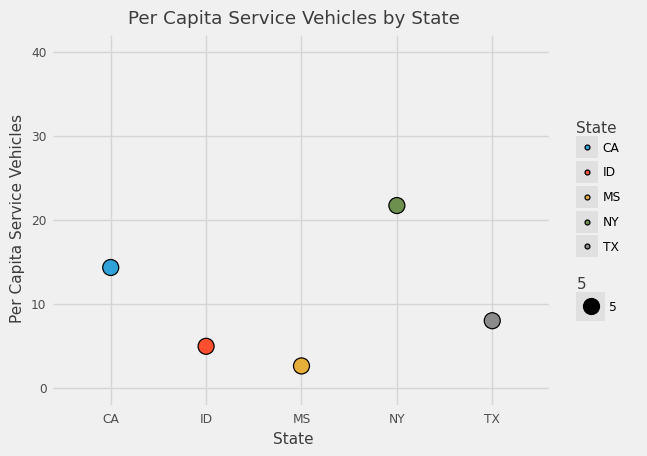

<ggplot: (8765062333558)>

In [98]:
(ggplot(per_capita, aes('State', 'Per_Capita_Service_Vehicles', size=5, 
                        fill= 'State'))
 + geom_point()) + labs(title = "Per Capita Service Vehicles by State", y = "Per Capita Service Vehicles", x = "State") +ylim(0,40) + theme_538() + scale_fill_manual(values=altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS)

In [108]:

alt.Chart(final_unlinked).mark_bar().encode(
    alt.X('State'),
    alt.Y('Weighted_Avg', title = "Average of Fare Revenue"),
    color =alt.Color('State', scale=alt.Scale(
                                  range=altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS)),
    tooltip = [alt.Tooltip('State'),
               alt.Tooltip('Weighted_Avg')
              ]
).interactive().properties(
    width=400,
    height=250,
    title = 'Average of Fare Revenue by Unlinked Passengers'
)

alt.Chart(...)